<a href="https://colab.research.google.com/github/google/cluster-data/blob/master/clusterdata_analysis_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google trace analysis colab

This colab provides several example queries and graphs using [Altair](https://altair-viz.github.io/) for the 2019 Google cluster trace. Further examples will be added over time.

**Important:** in order to be able to run the queries you will need to:

1.   Use the [Cloud Resource Manager](https://console.cloud.google.com/cloud-resource-manager) to Create a Cloud Platform project if you do not already have one.
2.   [Enable billing](https://support.google.com/cloud/answer/6293499#enable-billing) for the project.
3.   [Enable BigQuery](https://console.cloud.google.com/flows/enableapi?apiid=bigquery) APIs for the project.


In [ ]:
#@title Please input your project id
import pandas as pd
import numpy as np
import altair as alt
import os
from google.cloud import bigquery
from pyspark.sql import SparkSession 
# Provide credentials to the runtime
from google.cloud.bigquery import magics
import matplotlib.pyplot as plt

project_id = '' #@param {type:"string"}
client = bigquery.Client.from_service_account_json('', project=project_id)
print('Authenticated')
magics.context.project = project_id

# Use the client to run queries constructed from a more complicated function.
client = bigquery.Client(project=project_id)

Authenticated


# Basic queries

This section shows the most basic way of querying the trace using the [bigquery magic](https://googleapis.dev/python/bigquery/latest/magics.html)

In [36]:
query = '''
SELECT capacity.cpus AS cpu_cap, 
       capacity.memory AS memory_cap, 
       COUNT(DISTINCT machine_id) AS num_machines
FROM `google.com:google-cluster-data`.clusterdata_2019_a.machine_events
GROUP BY 1, 2
'''

# Execute the query
query_job = client.query(query)

# Fetch results
results = query_job.result()

# Print results
for row in results:
    print(f"cpu_cap: {row['cpu_cap']}, memory_cap: {row['memory_cap']}, num_machines: {row['num_machines']}")

cpu_cap: None, memory_cap: None, num_machines: 459
cpu_cap: 1.0, memory_cap: 0.5, num_machines: 1672
cpu_cap: 1.0, memory_cap: 1.0, num_machines: 643
cpu_cap: 1.0, memory_cap: 0.25, num_machines: 52
cpu_cap: 0.4794921875, memory_cap: 0.25, num_machines: 1
cpu_cap: 0.708984375, memory_cap: 0.33349609375, num_machines: 1417
cpu_cap: 0.708984375, memory_cap: 0.6669921875, num_machines: 480
cpu_cap: 0.708984375, memory_cap: 0.25, num_machines: 1
cpu_cap: 0.958984375, memory_cap: 0.5, num_machines: 179
cpu_cap: 0.958984375, memory_cap: 1.0, num_machines: 73
cpu_cap: 0.38671875, memory_cap: 0.33349609375, num_machines: 1104
cpu_cap: 0.38671875, memory_cap: 0.166748046875, num_machines: 670
cpu_cap: 0.591796875, memory_cap: 0.33349609375, num_machines: 3346
cpu_cap: 0.591796875, memory_cap: 0.166748046875, num_machines: 364


In [37]:
query = '''
SELECT COUNT(DISTINCT collection_id) AS collections
FROM `google.com:google-cluster-data`.clusterdata_2019_a.collection_events
'''

# Execute the query
query_job = client.query(query)

# Fetch results
results = query_job.result()

# Print results
for row in results:
    print(f"Number of collections: {row['collections']}")

Number of collections: 5212740


In [115]:
# Query to get the timestamps of events of type 0 (submit type) grouped every 5 minutes
import os
query ='''
  SELECT
    FLOOR(time / (5 * 60 * 1000000)) * (5) AS event_time_5_min_grouped,
    COUNT(*) AS submit_event_count
  FROM
    `google.com:google-cluster-data`.clusterdata_2019_a.instance_events
  WHERE
    type = 0
  GROUP BY
    event_time_5_min_grouped
  ORDER BY
    event_time_5_min_grouped
  '''
# Execute the query
query_job = client.query(query)

# Fetch results
results = query_job.result()

output_folder = "results"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

#store results in a file to be used in the next cell
with open('results/submit_events.csv', 'w') as f:
    for row in results:
        f.write(f"{row.event_time_5_min_grouped},{row.submit_event_count}\n")

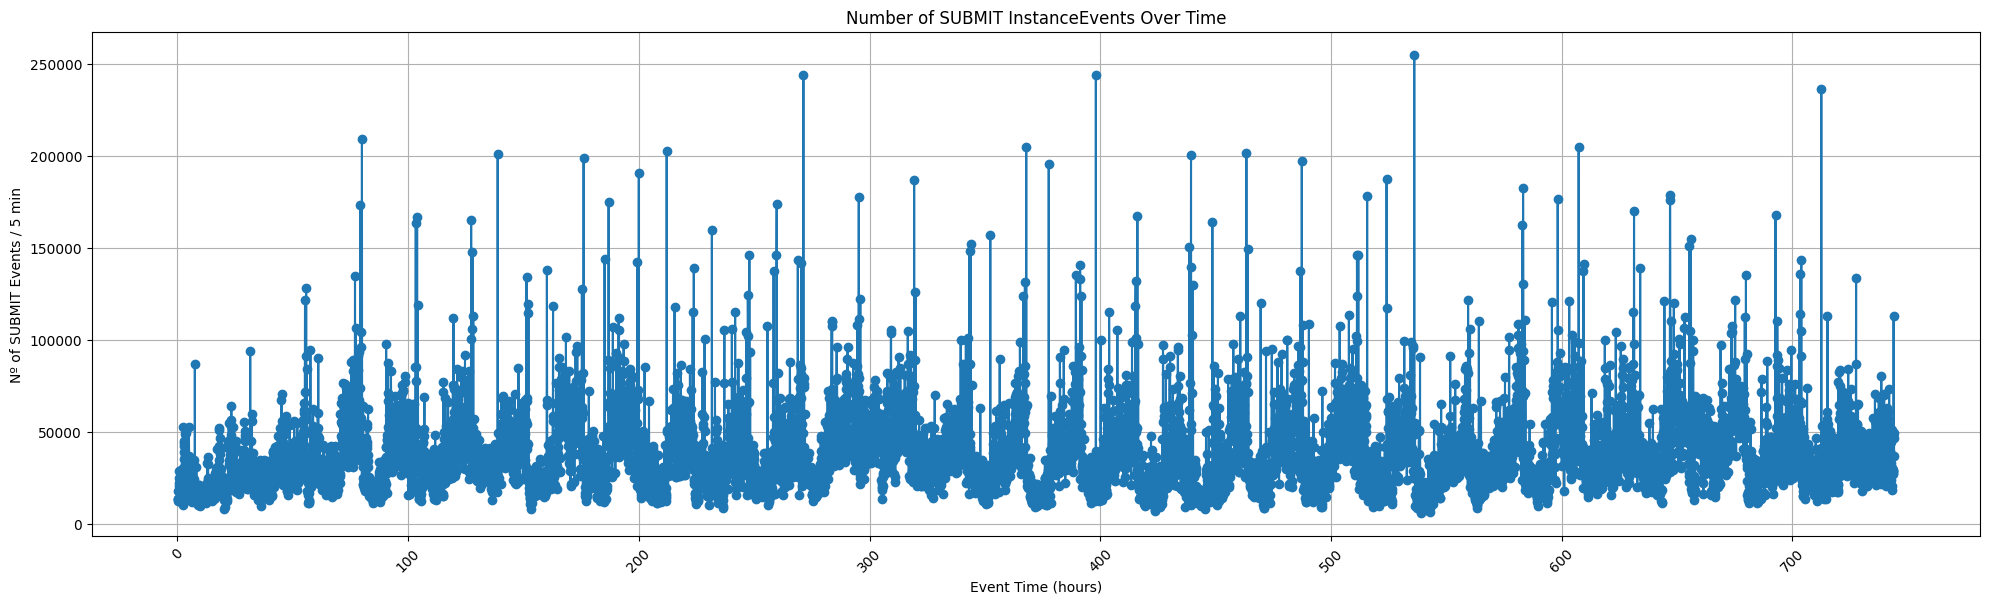

In [118]:
#retrieve data from results/submit_events.csv
results = pd.read_csv('results/submit_events.csv', names=['event_time_5_min_grouped', 'submit_event_count'])

#filter first and last elements of event_times and submit_counts because they are outliers
event_times = results['event_time_5_min_grouped'][1:-1]
submit_counts = results['submit_event_count'][1:-1]

#convert event_times to hours
event_times = np.array(event_times) / 60

plt.figure(figsize=(20, 6))
plt.plot(event_times, submit_counts, marker='o', linestyle='-')
plt.title('Number of SUBMIT InstanceEvents Over Time')
plt.xlabel('Event Time (hours)')
plt.ylabel('Nº of SUBMIT Events / 5 min')
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

# Cell level resource usage time series

This query takes a cell as input and plots a resource usage time-series for every hour of the trace broken down by tier.

In [ ]:
#@title Select a cell and a resource to plot the cell level usage series
def query_cell_capacity(cell):
  return '''
SELECT SUM(cpu_cap) AS cpu_capacity,
  SUM(memory_cap) AS memory_capacity
FROM (
  SELECT machine_id, MAX(capacity.cpus) AS cpu_cap,
    MAX(capacity.memory) AS memory_cap
  FROM `google.com:google-cluster-data`.clusterdata_2019_{cell}.machine_events
  GROUP BY 1
)
  '''.format(cell=cell)

def query_per_instance_usage_priority(cell):
  return '''
SELECT u.time AS time,
  u.collection_id AS collection_id,
  u.instance_index AS instance_index,
  e.priority AS priority,
  CASE
    WHEN e.priority BETWEEN 0 AND 99 THEN '1_free'
    WHEN e.priority BETWEEN 100 AND 115 THEN '2_beb'
    WHEN e.priority BETWEEN 116 AND 119 THEN '3_mid'
    ELSE '4_prod'
  END AS tier,
  u.cpu_usage AS cpu_usage,
  u.memory_usage AS memory_usage
FROM (
  SELECT start_time AS time,
    collection_id,
    instance_index,
    machine_id,
    average_usage.cpus AS cpu_usage,
    average_usage.memory AS memory_usage
  FROM `google.com:google-cluster-data`.clusterdata_2019_{cell}.instance_usage
  WHERE (alloc_collection_id IS NULL OR alloc_collection_id = 0)
    AND (end_time - start_time) >= (5 * 60 * 1e6)
) AS u JOIN (
  SELECT collection_id, instance_index, machine_id,
    MAX(priority) AS priority
  FROM `google.com:google-cluster-data`.clusterdata_2019_{cell}.instance_events
  WHERE (alloc_collection_id IS NULL OR alloc_collection_id = 0)
  GROUP BY 1, 2, 3
) AS e ON u.collection_id = e.collection_id
  AND u.instance_index = e.instance_index
  AND u.machine_id = e.machine_id
  '''.format(cell=cell)

def query_per_tier_utilization_time_series(cell, cpu_capacity, memory_capacity):
  return '''
SELECT CAST(FLOOR(time/(1e6 * 60 * 60)) AS INT64) AS hour_index,
  tier,
  SUM(cpu_usage) / (12 * {cpu_capacity}) AS avg_cpu_usage,
  SUM(memory_usage) / (12 * {memory_capacity}) AS avg_memory_usage
FROM ({table})
GROUP BY 1, 2 ORDER BY hour_index
  '''.format(table=query_per_instance_usage_priority(cell),
             cpu_capacity=cpu_capacity, memory_capacity=memory_capacity)
  
def run_query_utilization_per_time_time_series(cell):
  cell_cap = client.query(query_cell_capacity(cell)).to_dataframe()
  query = query_per_tier_utilization_time_series(
      cell,
      cell_cap['cpu_capacity'][0],
      cell_cap['memory_capacity'][0])
  time_series = client.query(query).to_dataframe()
  return time_series

cell = 'c' #@param ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
hourly_usage = run_query_utilization_per_time_time_series(cell)

# CPU graph
cpu = alt.Chart(hourly_usage).mark_area().encode(
        alt.X('hour_index:N'),
        alt.Y('avg_cpu_usage:Q'),
        color=alt.Color('tier', legend=alt.Legend(orient="left")),
        order=alt.Order('tier', sort='descending'),
        tooltip=['hour_index', 'tier', 'avg_cpu_usage']
  )
cpu.encoding.x.title = "Hour"
cpu.encoding.y.title = "Average CPU usage"
cpu.display()

# Memory graph
memory = alt.Chart(hourly_usage).mark_area().encode(
        alt.X('hour_index:N'),
        alt.Y('avg_memory_usage:Q'),
        color=alt.Color('tier', legend=alt.Legend(orient="left")),
        order=alt.Order('tier', sort='descending'),
        tooltip=['hour_index', 'tier', 'avg_memory_usage']
  )
memory.encoding.x.title = "Hour"
memory.encoding.y.title = "Average memory usage"
memory.display()

/Users/juliatribocabre/Desktop/KTH/Thesis/repos/cluster-data/env/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1820: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(
/Users/juliatribocabre/Desktop/KTH/Thesis/repos/cluster-data/env/lib/python3.11/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

/Users/juliatribocabre/Desktop/KTH/Thesis/repos/cluster-data/env/lib/python3.11/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

#Per machine resource usage distribution

This query takes a cell as input and plots a per-machine resource utilization CDF.

In [21]:
#@title Select a cell and plot its per-machine resource utilization CDFs

# Functions to plot CDFs using Altair
def pick_quantiles_from_tall_dataframe(data, qcol, name=""):
  quantiles = pd.DataFrame([x for x in data[qcol]]).transpose()
  if name != "":
    quantiles.columns = data[name]
  return quantiles

# - data: a dataframe with one row and one or more columns of quantiles (results
#   returned from APPROX_QUANTILES)
# - qcols: a list of names of the quantiles
# - names: the names of each returned quantiles' columns.
def pick_quantiles_from_wide_dataframe(data, qcols, names=[]):
    quantiles = {}
    for i, qcol in enumerate(qcols):
        col_name = qcol
        if i < len(names):
            col_name = names[i]
        quantiles[col_name] = data[qcol][0]
    return pd.DataFrame(quantiles)

# - quantiles: a dataframe where each column contains the quantiles of one
#   data set. The index (i.e. row names) of the dataframe is the quantile. The
#   column names are the names of the data set.
def plot_cdfs(quantiles, xlab="Value", ylab="CDF", legend_title="dataset", labels=[], interactive=False, title=''):
    dfs = []
    label = legend_title
    yval = range(quantiles.shape[0])
    esp = 1.0/(len(quantiles)-1)
    yval = [y * esp for y in yval]

    while label == xlab or label == ylab:
        label += '_'

    for col_idx, col in enumerate(quantiles.columns):
        col_label = col
        if col_idx < len(labels):
            col_label = labels[col_idx]
        dfs.append(pd.DataFrame({
            label: col_label,
            xlab: quantiles[col],
            ylab: yval
        }))
    
    cdfs = pd.concat(dfs)

    lines = alt.Chart(cdfs).mark_line().encode(
        x=alt.X(xlab+":Q", title=xlab),
        y=alt.Y(ylab+":Q", title=ylab),
        color=alt.Color(label+":N", legend=alt.Legend(orient="left"))
    ).properties(
        title=title
    )

    if not interactive:
        return lines

    nearest = alt.selection(type='single', nearest=True, on='mouseover', fields=[ylab], empty='none')
    selectors = alt.Chart(cdfs).mark_point().encode(
        y=alt.Y(ylab+":Q", title=ylab),
        opacity=alt.value(0)
    ).add_selection(
        nearest
    )

    text = lines.mark_text(align='left', dx=5, dy=-5).encode(
        text=alt.condition(nearest,
                           alt.Text(xlab+":Q", format=".2f"),
                           alt.value(' '))
    )

    rules = alt.Chart(cdfs).mark_rule(color='gray').encode(
        y=alt.Y(ylab+":Q", title=ylab)
    ).transform_filter(
        nearest
    )

    points = lines.mark_point().encode(
        opacity=alt.condition(nearest, alt.value(1), alt.value(0))
    )

    return alt.layer(lines, selectors, rules, text, points).interactive(bind_y=False)
  
# Functions to create the query

def query_machine_capacity(cell):
  return '''
SELECT machine_id, MAX(capacity.cpus) AS cpu_cap,
  MAX(capacity.memory) AS memory_cap
FROM `google.com:google-cluster-data`.clusterdata_2019_{cell}.machine_events
GROUP BY 1
  '''.format(cell=cell)

def query_top_level_instance_usage(cell):
  return '''
SELECT CAST(FLOOR(start_time/(1e6 * 300)) * (1000000 * 300) AS INT64) AS time,
  collection_id,
  instance_index,
  machine_id,
  average_usage.cpus AS cpu_usage,
  average_usage.memory AS memory_usage
FROM `google.com:google-cluster-data`.clusterdata_2019_{cell}.instance_usage
WHERE (alloc_collection_id IS NULL OR alloc_collection_id = 0)
  AND (end_time - start_time) >= (5 * 60 * 1e6)
  '''.format(cell=cell)

def query_machine_usage(cell):
  return '''
SELECT u.time AS time,
  u.machine_id AS machine_id,
  SUM(u.cpu_usage) AS cpu_usage,
  SUM(u.memory_usage) AS memory_usage,
  MAX(m.cpu_cap) AS cpu_capacity,
  MAX(m.memory_cap) AS memory_capacity
FROM ({instance_usage}) AS u JOIN
 ({machine_capacity}) AS m
ON u.machine_id = m.machine_id
GROUP BY 1, 2
  '''.format(instance_usage = query_top_level_instance_usage(cell),
             machine_capacity = query_machine_capacity(cell))
  
def query_machine_utilization_distribution(cell):
  return '''
SELECT APPROX_QUANTILES(IF(cpu_usage > cpu_capacity, 1.0, cpu_usage / cpu_capacity), 100) AS cpu_util_dist,
  APPROX_QUANTILES(IF(memory_usage > memory_capacity, 1.0, memory_usage / memory_capacity), 100) AS memory_util_dist
FROM ({table})
  '''.format(table = query_machine_usage(cell))

cell = 'c' #@param ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
query = query_machine_utilization_distribution(cell)
machine_util_dist = client.query(query).to_dataframe()
plot_cdfs(pick_quantiles_from_wide_dataframe(machine_util_dist, ['cpu_util_dist', 'memory_util_dist'], ['CPU', 'Memory']), xlab='x - resource utilization (%)', ylab="Probability (resource utilization < x)", interactive=True)

/Users/juliatribocabre/Desktop/KTH/Thesis/repos/cluster-data/env/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1820: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(
/Users/juliatribocabre/Desktop/KTH/Thesis/repos/cluster-data/env/lib/python3.11/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'selection' is deprecated.
   Use 'selection_point()' or 'selection_interval()' instead; these functions also include more helpful docstrings.
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
/Users/juliatribocabre/Desktop/KTH/Thesis/repos/cluster-data/env/lib/python3.11/site-packages/altair/vegalite/v5/api.py:418: AltairDeprecationWarning: The types 'single' and 'multi' are now
        combined and should be specified using "selection_point()".
  warnings.warn(
/Users/juliatribocabre/Desktop/KTH/Thesis/repos/cluster-data/env/lib/python3.11/site-packages/altair/vegalite/v5/api.py:355: A

alt.LayerChart(...)